# Dipendenze

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install pillow numpy matplotlib tensorflow[and-cuda]

# Imports

In [1]:
import os
import time
import zipfile
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL.Image as pillow

2025-01-20 08:46:03.153146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737362763.173136    1827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737362763.179627    1827 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 08:46:03.200176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print(f"TensorFlow version: {tf.__version__}")
for i, dev in enumerate(tf.config.list_physical_devices(device_type="GPU")):
    print(f"\t* Available {dev.device_type} #{i}: {dev.name}")

TensorFlow version: 2.18.0
	* Available GPU #0: /physical_device:GPU:0


# Estrazione del dataset

In [3]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

### Calcolo della media della dimensione delle immagini del dataset

In [4]:
ws = []
hs = []

start = time.time()

for root, dirs, files in os.walk(DATASET_IMGS_DESTDIR + "animals"):
    path = root.split(os.sep)
    for file in files:
        mypath = f"{DATASET_IMGS_DESTDIR}animals/{os.path.basename(root)}/{file}"
        img = pillow.open(mypath)
        w,h = img.size
        ws.append(w)
        hs.append(h)

avg = lambda n: sum(n) / len(n)

avg_w = int(avg(ws))
avg_h = int(avg(hs))

end = time.time()

print(f"done. it took {end - start:.2f} secs.\navg_w = {avg_w}, avg_h = {avg_h}")

done. it took 24.45 secs.
avg_w = 319, avg_h = 252


# Caricamento del dataset e split

In [18]:
INPUT_SHAPE=(avg_w, avg_w, 3)
BATCH_SIZE=16

training_set, testing_set = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.3,
    image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    label_mode="categorical",
    batch_size=BATCH_SIZE)

training_set_size = int(0.8 * len(training_set))
validation_set_size = int(0.2 * len(training_set))
__Training_set = training_set.take(training_set_size)
validation_set = training_set.skip(training_set_size).take(validation_set_size)
training_set = __Training_set

print(f"num of training set batches: {len(training_set)} so {len(training_set) * BATCH_SIZE} elems")
print(f"num of validation set batches: {len(validation_set)} so {len(validation_set) * BATCH_SIZE} elems")
print(f"num of testing set batches: {len(testing_set)} so {len(testing_set) * BATCH_SIZE} elems")

Found 26128 files belonging to 10 classes.
Using 18290 files for training.
Using 7838 files for validation.
num of training set batches: 915 so 14640 elems
num of validation set batches: 228 so 3648 elems
num of testing set batches: 490 so 7840 elems


# Costruzione del modello

In [19]:
def build_model(your_base_model):
    top_layers = 0

    def atlay(x):
        nonlocal top_layers
        top_layers += 1
        return x
        
    seq_model = keras.Sequential([
        keras.Input(shape=INPUT_SHAPE),
        keras.layers.Rescaling(scale=1./127.5, offset=-1),
        your_base_model(include_top=False, input_shape=INPUT_SHAPE),
        atlay(keras.layers.GlobalAveragePooling2D()),
        atlay(keras.layers.Dropout(0.25)),
        atlay(keras.layers.Dense(
            10,
            bias_initializer=keras.initializers.GlorotUniform(),
            activation=keras.activations.softmax))
    ])
    
    freezing_layers = seq_model.layers[:len(seq_model.layers) - top_layers]
    for layer in freezing_layers:
        layer.trainable = False

    return (seq_model, top_layers)

In [20]:
(model, model_added_top_layers) = build_model(keras.applications.MobileNet)
model.summary()

/tmp/ipykernel_1827/1933013391.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  your_base_model(include_top=False, input_shape=INPUT_SHAPE),


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 319, 319, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 10, 10, 1024)   │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Addestramento del modello

## Transfer learning

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy()
    ])

transfer_history = model.fit(
    training_set,
    validation_data=validation_set,
    validation_freq=3,
    epochs=40,
    callbacks=[
        keras.callbacks.EarlyStopping(
            start_from_epoch=3,
            patience=2,
            restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(
            lambda e, l: l if e < 1 else l * np.exp(-0.15)
        )])

val_loss, val_categorical_accuracy = model.evaluate(validation_set)

Epoch 1/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - categorical_accuracy: 0.7534 - loss: 0.8025 - learning_rate: 0.0010
Epoch 2/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9475 - loss: 0.1853 - learning_rate: 8.6071e-04
Epoch 3/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - categorical_accuracy: 0.9561 - loss: 0.1495 - val_categorical_accuracy: 0.9600 - val_loss: 0.1316 - learning_rate: 7.4082e-04
Epoch 4/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9567 - loss: 0.1381 - learning_rate: 6.3763e-04
Epoch 5/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9626 - loss: 0.1207 - learning_rate: 5.4881e-04
Epoch 6/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9645 - loss: 0.1155 

2025-01-20 09:12:09.589428: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19538944 bytes after encountering the first element of size 19538944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


915/915 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - categorical_accuracy: 0.9645 - loss: 0.1155 - val_categorical_accuracy: 0.9644 - val_loss: 0.1189 - learning_rate: 4.7237e-04
Epoch 7/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9683 - loss: 0.1067 - learning_rate: 4.0657e-04
Epoch 8/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9722 - loss: 0.0985 - learning_rate: 3.4994e-04
Epoch 9/40
914/915 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9730 - loss: 0.0921 

2025-01-20 09:12:59.734693: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19538944 bytes after encountering the first element of size 19538944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


915/915 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - categorical_accuracy: 0.9730 - loss: 0.0921 - val_categorical_accuracy: 0.9671 - val_loss: 0.1113 - learning_rate: 3.0119e-04
Epoch 10/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9694 - loss: 0.0985 - learning_rate: 2.5924e-04
Epoch 11/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9724 - loss: 0.0908 - learning_rate: 2.2313e-04
Epoch 12/40
913/915 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9711 - loss: 0.0892 

2025-01-20 09:13:47.637834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19538944 bytes after encountering the first element of size 19538944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


915/915 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - categorical_accuracy: 0.9711 - loss: 0.0892 - val_categorical_accuracy: 0.9688 - val_loss: 0.1083 - learning_rate: 1.9205e-04
Epoch 13/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9749 - loss: 0.0831 - learning_rate: 1.6530e-04
Epoch 14/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9729 - loss: 0.0889 - learning_rate: 1.4227e-04
Epoch 15/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 45s 49ms/step - categorical_accuracy: 0.9758 - loss: 0.0871 - val_categorical_accuracy: 0.9690 - val_loss: 0.1084 - learning_rate: 1.2246e-04
Epoch 16/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9772 - loss: 0.0804 - learning_rate: 1.0540e-04
Epoch 17/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9774 - loss: 0.0794 - learning_rate: 9.0718e-05
Epoch 18/40
914/915 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9764 - loss: 0.0776 

2025-01-20 09:15:48.571141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19538944 bytes after encountering the first element of size 19538944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


915/915 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - categorical_accuracy: 0.9764 - loss: 0.0776 - val_categorical_accuracy: 0.9698 - val_loss: 0.1070 - learning_rate: 7.8082e-05
Epoch 19/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9731 - loss: 0.0829 - learning_rate: 6.7206e-05
Epoch 20/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9750 - loss: 0.0819 - learning_rate: 5.7844e-05
Epoch 21/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - categorical_accuracy: 0.9752 - loss: 0.0803 - val_categorical_accuracy: 0.9685 - val_loss: 0.1070 - learning_rate: 4.9787e-05
Epoch 22/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - categorical_accuracy: 0.9746 - loss: 0.0813 - learning_rate: 4.2852e-05
Epoch 23/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - categorical_accuracy: 0.9776 - loss: 0.0751 - learning_rate: 3.6883e-05
Epoch 24/40
915/915 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - categorical_accuracy: 0.9749 - loss: 0.0768 - val_categorical_accuracy: 0

## Salvataggio pesi correnti

In [27]:
print(f"saving model ({model.layers[1].name}) weights with val_loss = {val_loss:.4f}, val_categorical_accuracy = {val_categorical_accuracy:.4f}")
weights_filename=f"./{model.layers[1].name}_tl_noqnt_noft.weights.h5"
model.save_weights(weights_filename)
print(f"done: {weights_filename}")

saving model (mobilenet_1.00_224) weights with val_loss = 0.1069, val_categorical_accuracy = 0.9701
done: ./mobilenet_1.00_224_tl_noqnt_noft.weights.h5


# Provare a fare predizioni

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-01-20 09:20:07.027413: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


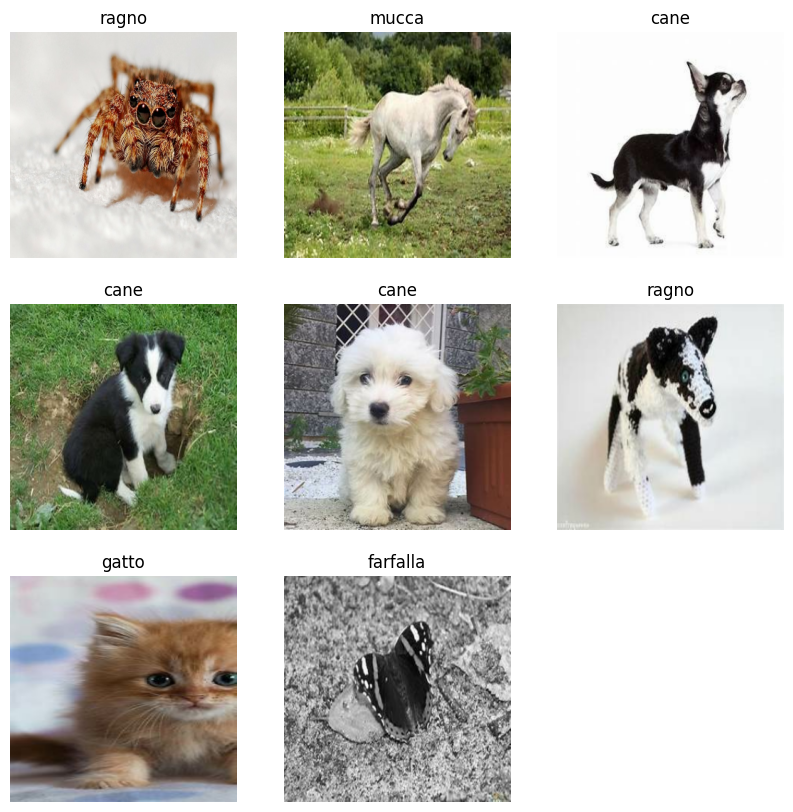

In [29]:
def predict_3x3_from_dataset(dataset, m):
    d = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

    shuffled_dataset = dataset.take(1).shuffle(buffer_size=1000)
    plt.figure(figsize=(10, 10))
    for images, labels in shuffled_dataset:
      for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        resized = tf.image.resize([images[i]], (INPUT_SHAPE[0], INPUT_SHAPE[1]))
        inputs = tf.reshape(resized, (1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        y = m.predict(inputs)
        plt.title(d[np.argmax(y)])
        plt.axis("off")

predict_3x3_from_dataset(validation_set, model)